In [1]:
library(rvest)
library(stringr)
library(tidyverse)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()         masks stats::filter()
✖ readr::guess_encoding() masks rvest::guess_encoding()
✖ dplyr::lag()            masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


We are going to use two datasets cooperatively in this project. Below is the information about each dataset.
### Dataset 1: "sessions.csv"
* Number of observations: 1535
* Number of variables: 5
* Names and types of variables:
* * 3 variables of type chr (string): hashedEmail, start_time, end_time
* * 2 variables of type dbl (numeric): original_start_time, original_end_time
* Meaning of each variable:
* * hashedEmail: A hashed format of the email address
* * start_time: The start time of each session when the player begins playing the game
* * end_time: The end time of each session when the player finishes playing the game
* * original_start_time: The start time represented as a timestamp in scientific notation (milliseconds since January 1, 1970) for each session that the player start to play the game. 
* * original_end_time: The end time represented as a timestamp in scientific notation (milliseconds since January 1, 1970) for each session that the player start to play the game. 

The data is collected as event logs when users play the game.

#### Potential issues:
* start_time and end_time are in string format. To calculate the time the users spend, we need to convert these columns into a numerical format that allows for mathematical calculations (end_time - start_time).
* original_start_time and original_end_time are stored in scientific notation. These timestamps may need to be converted into a human-readable time format before calculating the difference to determine the time a player spent. For example, May 26, 2023, 01:49:30 UTC and June 18, 2023, 16:00:00 UTC if these 2 are the variables of interest.

### Dataset 2: "players.csv"
* Number of observations: 196
* Number of variables: 9
* Names and types of variables:
* * 4 variables of type chr (string):hashedEmail, experience, name, gender
* * 2 variables of type dbl (numeric):played_hours, age
* * 3 variables of type lgl (Boolean):subscribe, individualId, organizationName
* Meaning of each variable:
* * hashedEmail: A hashed format of the email address
* * experience: Categorizes the player’s experience level into five groups: Pro, Veteran, Amateur, Regular, and Beginner
* * name: The player’s name
* * gender: The player’s gender
* * played_hours: The total number of hours the player has spent playing the game
* * age: The player’s age
* * subscribe: Whether the player subscribes to the game or not
* * individualId: The ID for each individual
* * organizationName: The name of the organization associated with the observation
#### Potential issues:
* The individualId and organizationName columns are empty, contain missing values.
* How is the experience level categorized? Is there a standard for this, or is it self-reported by the player? More associated clarification needed. 

#### Question:

What predicts which players will contribute more time in game than others? Specifically, we are interested in MineCraft game players - can their age, experience level and average time per play session predict the total play hour they spend on this game. 

#### Plan to wrangle the data:

We would like to use the KNN regression method to predict the total play hours spent on the game based on players' experience level, age, and average time per play session. First, in "sessions.csv", convert the start_time and end_time columns into a numerical format, then create a new column called time_each_session by calculating end_time - start_time. Next, group the data by hashedEmail and summarize it, showing the average time per play session for each player. After that, merge the two dataframes based on hashedEmail. Finally, split the combined dataset into trainig set and testing set. Perform data training to find the best K on training set and then do prediction on testing set, find RMSPE value to determine if this is a good model. 

In [2]:
players_link<-"https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players<-read_csv(players_link)
# players
sessions<-read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")
# sessions


Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
#wrangle data, per session time in minutes
sessions$start_time <- as.POSIXct(sessions$start_time, format = "%d/%m/%Y %H:%M")
sessions$end_time <- as.POSIXct(sessions$end_time, format = "%d/%m/%Y %H:%M")
sessions <- sessions %>%
  mutate(time_per_session_in_min = as.numeric(difftime(end_time, start_time, units = "mins")))



#group and summarized average play time per session in hours based on hashedmail.
new_sessions<-sessions|>
group_by(hashedEmail)|>
summarize(avg_play_t_in_h=mean(time_per_session_in_min/60))
# new_sessions

#conbine the 2 dataframe
conbined_df<-left_join(players,new_sessions)
# conbined_df

Joining with `by = join_by(hashedEmail)`


Warning message:
“Removed 73 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 73 rows containing missing values or values outside the scale range
(`geom_point()`).”


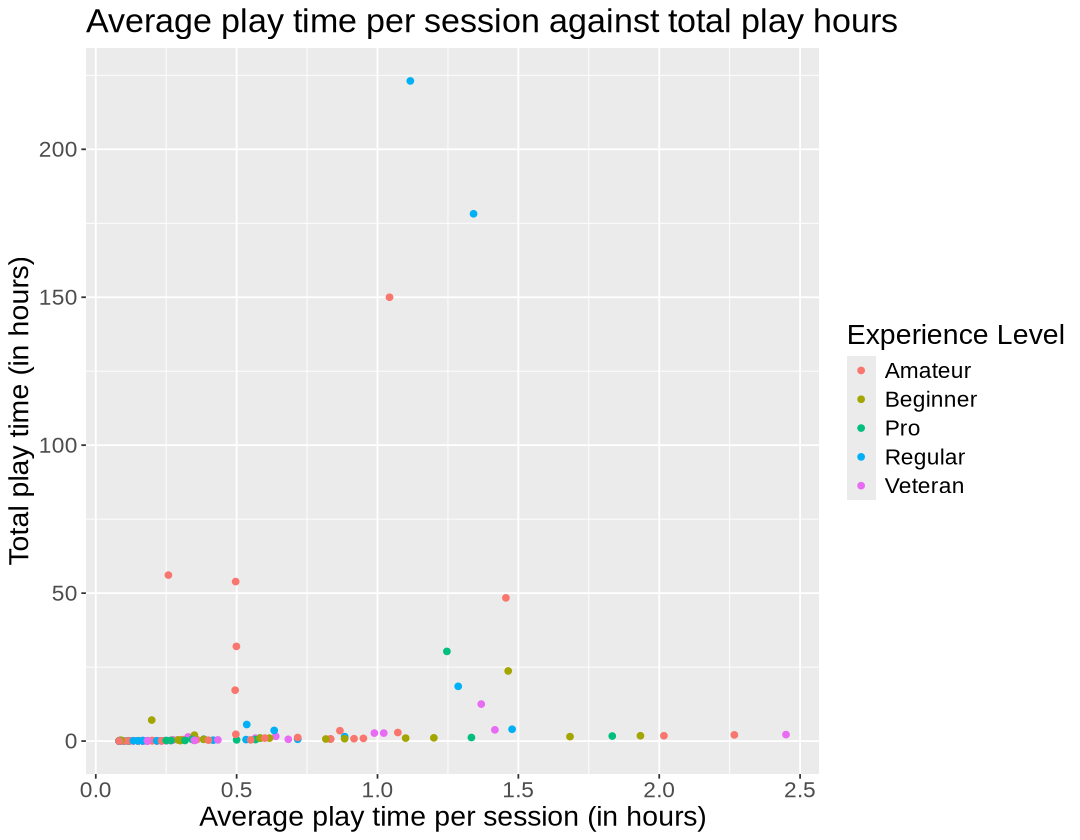

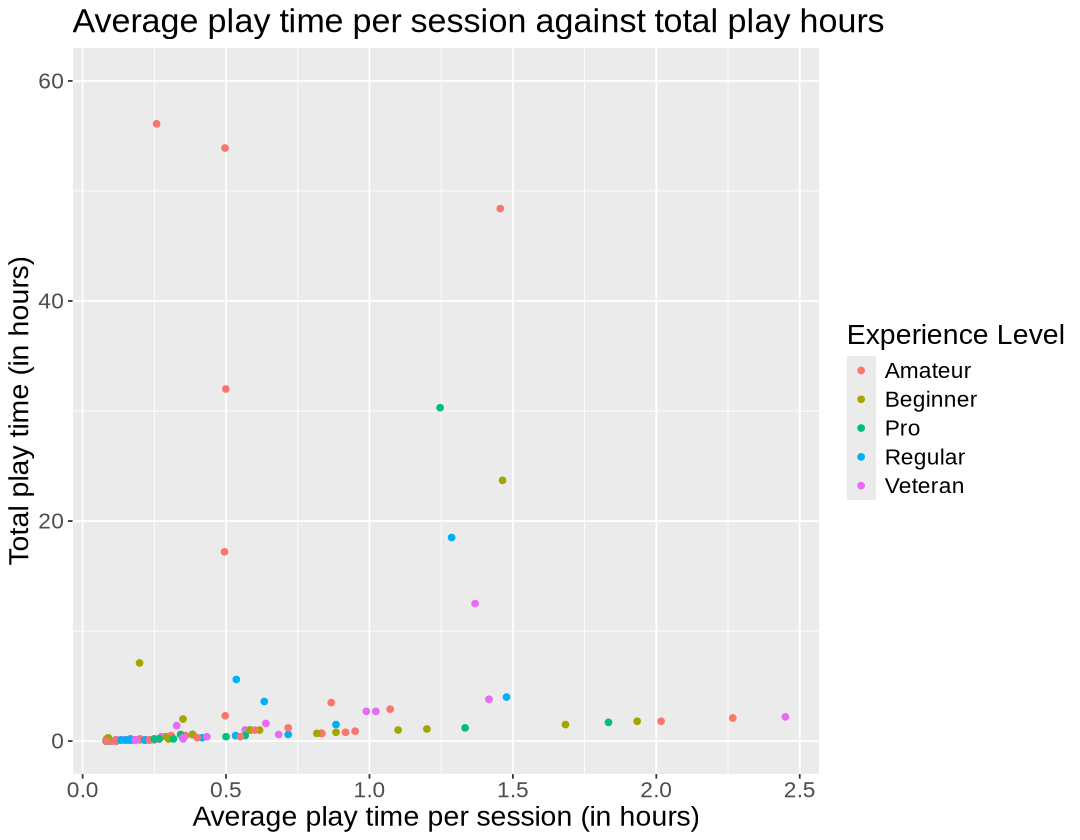

In [17]:
#see the plot of average play time per session (in hours) against total play hours
options(repr.plot.width = 9, repr.plot.height = 7) 
plot<-ggplot(conbined_df,aes(x=avg_play_t_in_h,y=played_hours, color=experience))+
geom_point()+
ggtitle("Average play time per session against total play hours")+
labs(x="Average play time per session (in hours)", y="Total play time (in hours)", color="Experience Level")+
theme(text=element_text(size=17))

plot

#zoom in plot to see majority
plot+coord_cartesian(ylim = c(0, 60)) 

#### Insights

From the plots above we can see there is no linear relationship between average play time per session (in hours) and total play hours. Linear regression may not be a good model. 

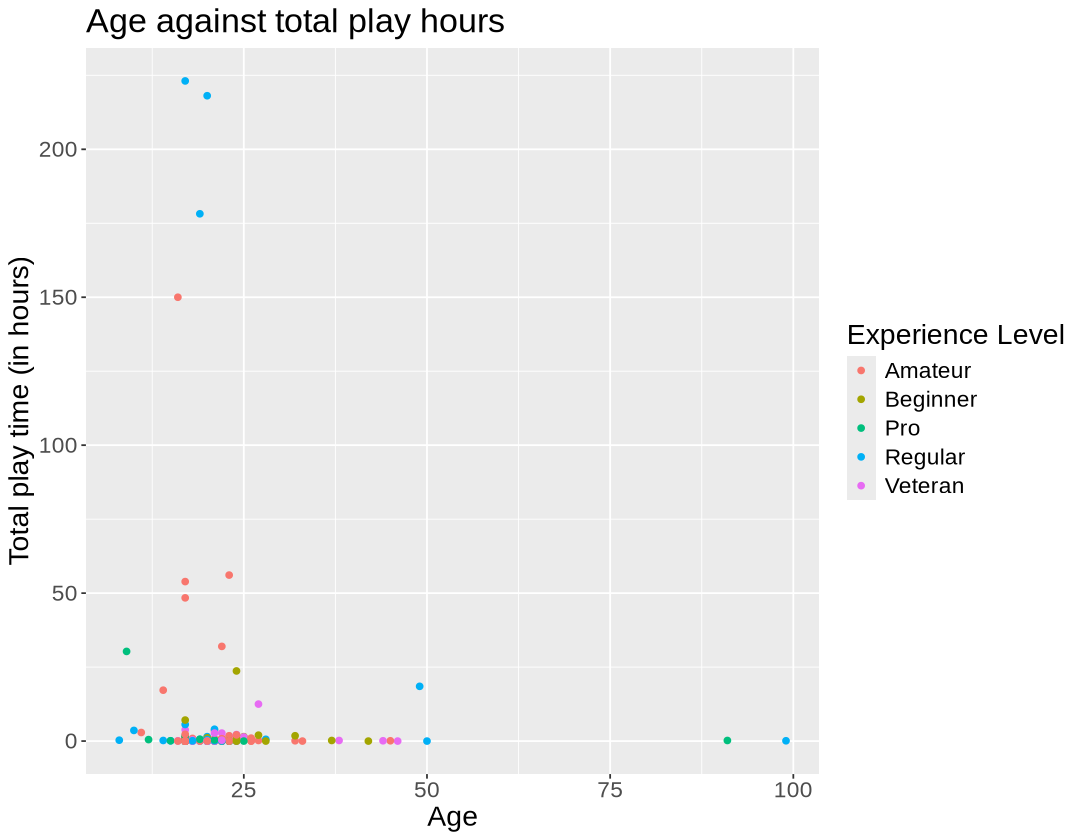

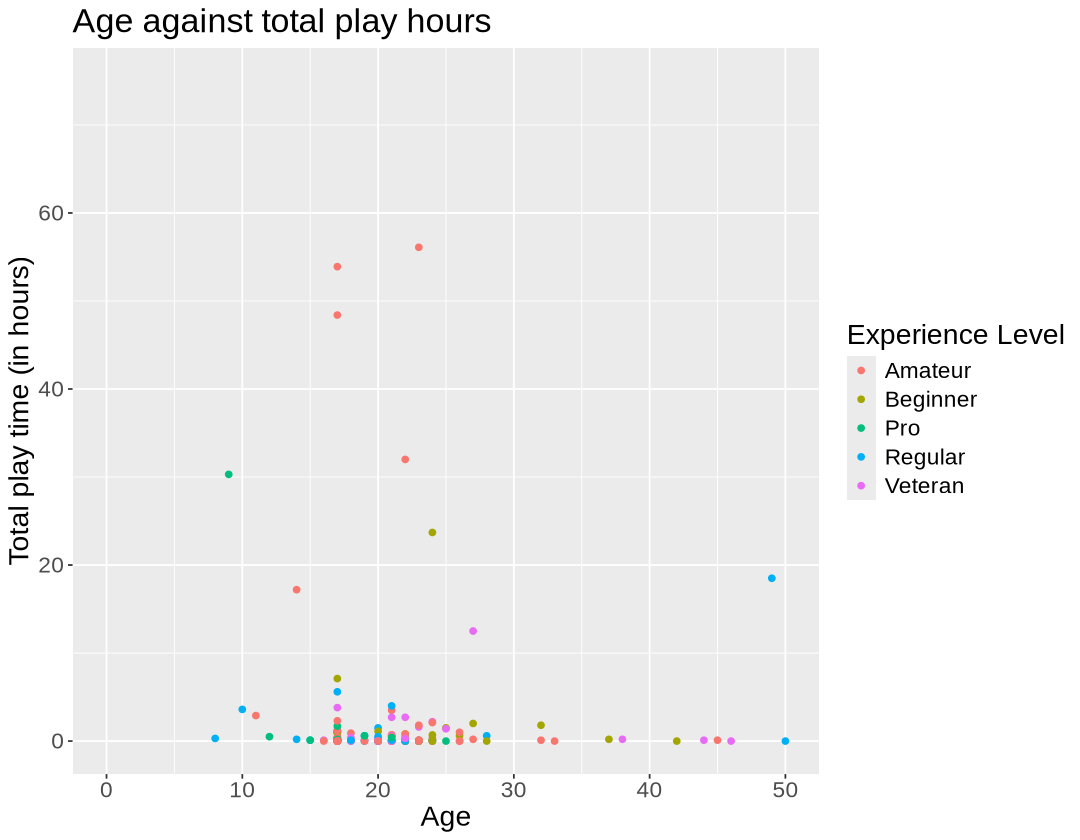

In [18]:
#see the plot of age against total play hours
options(repr.plot.width = 9, repr.plot.height = 7) 
plot2<-ggplot(conbined_df,aes(x=age,y=played_hours, color=experience))+
geom_point()+
ggtitle("Age against total play hours")+
labs(x="Age", y="Total play time (in hours)", color="Experience Level")+
theme(text=element_text(size=17))

plot2
#most of our player are aged equal or below 50. 

#zoom in plot to see majority
plot2+coord_cartesian(xlim = c(0, 50),ylim = c(0, 75)) 

#### Insights

From the plots above we can see there is no linear relationship between age and total play hours. Linear regression may not be a good model. 

In [9]:
#see the table and find out how many people of each age group reported in their experience level respectively
table<-conbined_df|>
mutate(age_group = cut(age, breaks=seq(1,110,10)))|>
group_by(experience, age_group)|>
summarize(count=n())
table

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


experience,age_group,count
<chr>,<fct>,<int>
Amateur,"(1,11]",1
Amateur,"(11,21]",41
Amateur,"(21,31]",18
Amateur,"(31,41]",2
Amateur,"(41,51]",1
Beginner,"(11,21]",18
Beginner,"(21,31]",14
Beginner,"(31,41]",2
Beginner,"(41,51]",1


#### Insights

From the table above, we can see how many players in each age group fall into each experience level. The three highest player count group among the table are in the age group 11-21, reported as 'Amateur', 'Regular', or 'Veteran' experience level. We may want to focus our recruitment efforts on these groups, mostly teenagers.

#### Method and Plan
We are going to use the k-nearest neighbors (KNN) regression algorithm on the combined two datasets. This is because, first, our response variable is numerical (total paly hours on Minecraft), and second, we don’t want to make assumptions about the underlying data distribution. Additionally, we don't see a linear relationship between our target variable and the predictor variables based on the graph, so KNN regression is a good choice. The assumption behind KNN is that similar points tend to be near each other.

However, one limitation of KNN is its sensitivity to noise and outliers. If an outlier is close to the test point, KNN may incorrectly predict the target value.

After combining the two dataframes based on hashedEmail, we will split the new combined dataset into a training set (75%) and a testing set (25%). Find the best value of K on trainig dataset. During the process of finding the best K, we will also use 5-fold cross-validation and a series of K-vals.